# REGIONAL Ascending 101 Stack and Time Series

NOTES:
- data covers approx 3x3degree aread (300^2 km^2)
- unwrapped at ~90m ground resultion & filtered
- geocoded at 30m posting to match processing DEM (10800x 10802 pixels --> 446Mb per array)
- looks.py to reduce resoltion (8alks, 8rlks) --> (1350x 1350 pixels --> 7Mb per array)
    - 78 12-day pairs --> 1Gb (b/c 2 arrays per file)
        - cut file transfer sizes in half by extracting phs band and converting to mm on server
        - gdal_calc.py -A filt_topophase.unw.geo.vrt --A_band=2 --calc="A*0.05546576/12.5663706" --outfile=filt_topophase.unw_m.geo  --format=ENVI --NoDataValue=-9999 --overwrite
        - gdalwarp -overwrite -of VRT -t_srs EPSG:32736 filt_topophase.unw_m.geo filt_topophase.unw_m.geo.utm.vrt

In [1]:
import numpy as np
import rasterio
import iscefunctions as util
import pyproj
import matplotlib.pyplot as plt
import matplotlib.dates as pltdate
import vmodels as vm
import pandas as pd
import geopandas as gpd
import os
import glob

In [2]:
#%matplotlib inline
%matplotlib notebook
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['font.size'] = '16' #For Poster
%qtconsole

In [3]:
# Directory of coseismic interferograms
datadir = '/Users/scott/Desktop/EastAfrica/insar/A101/regional_timeseries/'
pairs = [x for x in os.listdir(datadir) if x.startswith('int')]
#pairs.sort()
nlks = '.8alks_8rlks.'
auxfiles = '/Users/scott/Desktop/EastAfrica/insar/A101/auxfiles/'
unwFile = 'merged/filt_topophase.unw_m{}geo.utm.vrt'.format(nlks)
#concompFile = 'filt_topophase.unw.conncomp{}geo.vrt'.format(nlks) #ignore for now...
#corFile = 'topophase.cor{}geo.vrt'.format(nlks)

# Need to make aux files...
#losFile = auxfiles + 'los_regional{}geo.utm.vrt'.format(nlks)
enuFile = auxfiles + 'enu_regional{}geo.utm.vrt'.format(nlks) #pre-convert los into cartesian multipliers
swbdFile = auxfiles + 'swbd_regional{}geo.utm.vrt'.format(nlks)
demFile = auxfiles + 'dem_regional{}geo.utm.vrt'.format(nlks)

epsg = 32736  #UTM 36S WGS84
wavelength = 55.46576 #mm

In [4]:
epi_segment = (33.836, -9.87) 
utm36s = pyproj.Proj('+init=EPSG:{}'.format(epsg))
xcen,ycen = utm36s(*epi_segment)
print(xcen,ycen)
lon,lat = utm36s(xcen,ycen,inverse=True)
print(lon,lat)

591661.1098421689 8908846.078686059
33.836 -9.870000000000003


In [5]:
os.chdir(datadir)
pairs = glob.glob('int*')
pairs.sort()
print('#pairs: ', len(pairs))

#pairs:  119


In [6]:
# Ignore perpendicular baseline for now...
#df = pd.read_csv('summary.txt', names=['directory','bperp'], delim_whitespace=True)
dfAll = pd.DataFrame(pairs, columns=['directory'])
dfAll['primary'] = pd.to_datetime(dfAll.directory.str[4:12], format='%Y%m%d')
dfAll['secondary'] = pd.to_datetime(dfAll.directory.str[13:], format='%Y%m%d')
dfAll['dt'] = dfAll.primary - dfAll.secondary
dfAll.head()

,directory,primary,secondary,dt
0,int_20141117_20141012,2014-11-17,2014-10-12,36 days
1,int_20141117_20141024,2014-11-17,2014-10-24,24 days
2,int_20141129_20141012,2014-11-29,2014-10-12,48 days
3,int_20141129_20141024,2014-11-29,2014-10-24,36 days
4,int_20141129_20141117,2014-11-29,2014-11-17,12 days


In [7]:
# Some basic info about the set
dates = np.unique(np.append(dfAll.primary.values, dfAll.secondary.values))
#print(dfB.dateStr.iloc[0], ' to ', dfB.dateStr.iloc[-1])
print(len(dfAll), ' Interferograms')
print(len(dates), 'Dates')
print('First Date: ', dfAll.secondary.iloc[0])
print('Second Date: ', dfAll.primary.iloc[-1])

119  Interferograms
82 Dates
First Date:  2014-10-12 00:00:00
Second Date:  2017-04-11 00:00:00


<IPython.core.display.Javascript object>


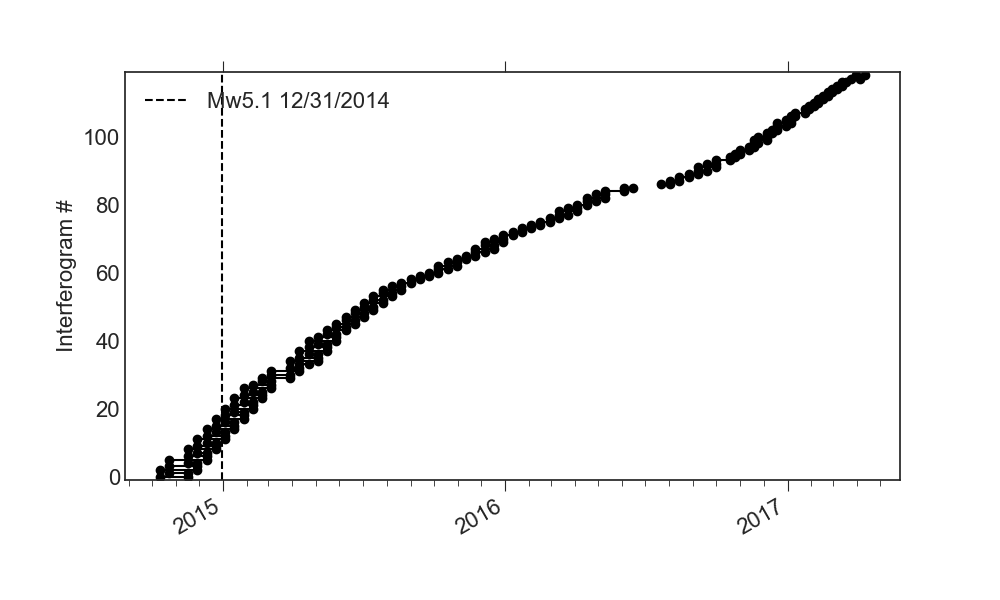

In [8]:
#from matplotlib.ticker import FixedLocator
from matplotlib.dates import MonthLocator, DateFormatter
fig, ax = plt.subplots(figsize=(10,6))
for i,row in dfAll.iterrows():
    plt.plot([row.secondary, row.primary], [i,i],  'ko-')
    midx = row.secondary + (row.primary - row.secondary)/2
    #plt.text(midx, i+0.25, int(row.bperp))

eq = pd.to_datetime('20141231', format='%Y%m%d')
plt.axvline(eq, linestyle='dashed', color='k', label='Mw5.1 12/31/2014')
plt.ylim(-1,i+1)
plt.ylabel('Interferogram #')
plt.legend(loc='upper left')
#plt.xticks(dates)
#ax.xaxis.set_major_formatter(DateFormatter("%m/%d/%Y")) #too many dates!
#fig.autofmt_xdate()

months = pltdate.MonthLocator()
years = pltdate.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months) #too much
ax.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')
plt.tick_params(axis='x', which='minor', bottom=True, length=4)
plt.tick_params(axis='x', which='major', bottom=True, length=8)
plt.tick_params(labelleft=True, bottom=True, top=True, right=True, left=True)
fig.autofmt_xdate()

In [8]:
# Count number of pairs for each date
def summarize_dates(df):
    dfDates = pd.DataFrame(index=np.unique(df.primary.append(df.secondary)), columns=['count'])
    dfDates['p_pairs'] = df.groupby('primary').secondary.count()
    dfDates['s_pairs'] = df.groupby('secondary').primary.count()
    dfDates = dfDates.fillna(0)
    dfDates['count'] = dfDates.p_pairs + dfDates.s_pairs
    return dfDates

In [9]:
# Plot first 5
def load_mm(path, mask=None):
    ''' unwrapped single band files alread converted to mm'''
    data,extent,metadata = util.load_rasterio(path)
    mm = data[0]
    mm[ (mm == metadata['nodata']) ] = np.nan  #gets edge nans
    mm[ (mm == 0) ] = np.nan  #gets off-swath nans
    mm = mm*1e3 #convert to mm
    #mm = phs*wavelength/12.5663706
    
    if type(mask) == np.ndarray:
        mm[mask] = np.nan
    
    return mm,extent,metadata

In [10]:
def plot_histogram(mm):
    plt.figure()
    mean = np.nanmean(mm)
    junk = plt.hist(mm[np.isfinite(mm)], bins=100)
    plt.axvline(mean, color='r',lw=2, label=mean)
    plt.title(pair)
    plt.xlabel('dLOS [mm]')
    plt.legend(loc='upper left')

In [11]:
def plot_image(mm, extent=None, vmin=None, vmax=None, cmap='viridis',title=''):
    plt.figure()
    plt.imshow(mm, extent=None, cmap=cmap, vmin=vmin, vmax=vmax)
    cb = plt.colorbar()
    cb.set_label('dLOS [mm]')
    plt.title(title)

In [14]:
ifg = 5
pair = dfAll.directory.iloc[ifg]
path = os.path.join(datadir,pair,unwFile)
mm,extent,metadata = load_mm(path)
extent_km = np.array(extent)/1e3

<IPython.core.display.Javascript object>


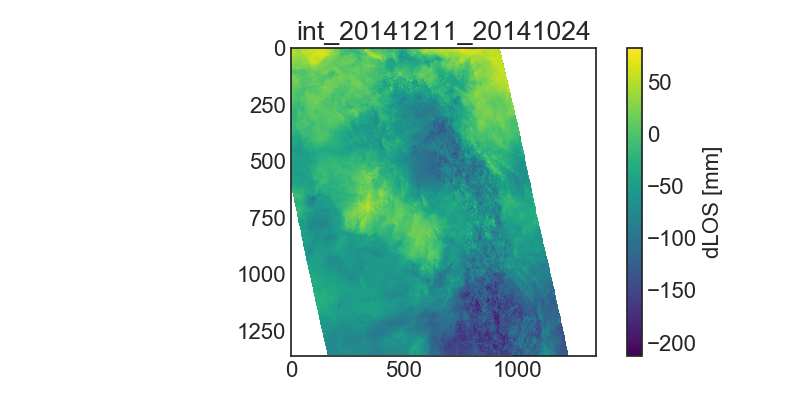

In [15]:
plot_image(mm, title=pair)

<IPython.core.display.Javascript object>


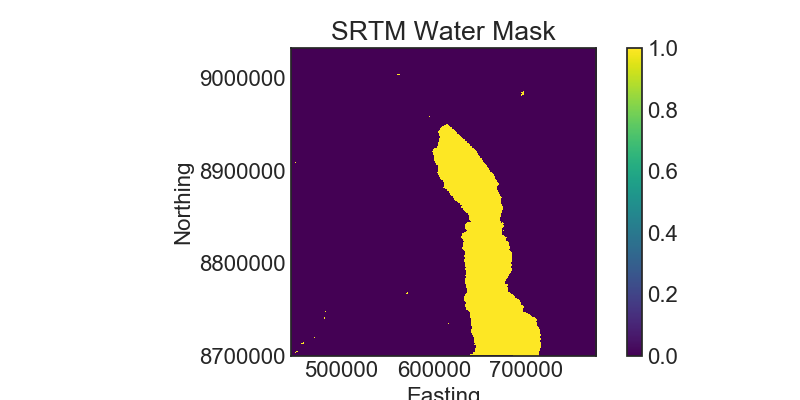

In [16]:
# Get Water Mask
plt.figure()
data,junk,junk = util.load_rasterio(swbdFile)
water = data[0].astype('bool')
plt.imshow(water, extent=extent)#, cmap='viridis')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('SRTM Water Mask')
plt.colorbar()

<IPython.core.display.Javascript object>


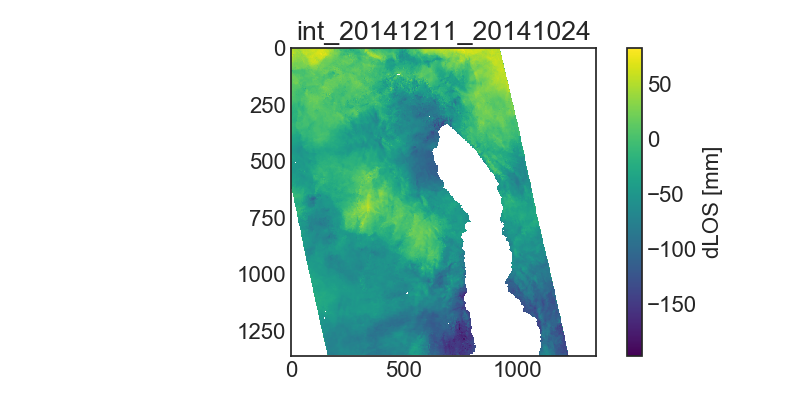

In [151]:
ifg = 5
pair = dfAll.directory.iloc[ifg]
path = os.path.join(datadir,pair,unwFile)
mm,extent,metadata = load_mm(path, mask=water)
extent_km = np.array(extent)/1e3

plot_image(mm, title=pair)

<IPython.core.display.Javascript object>


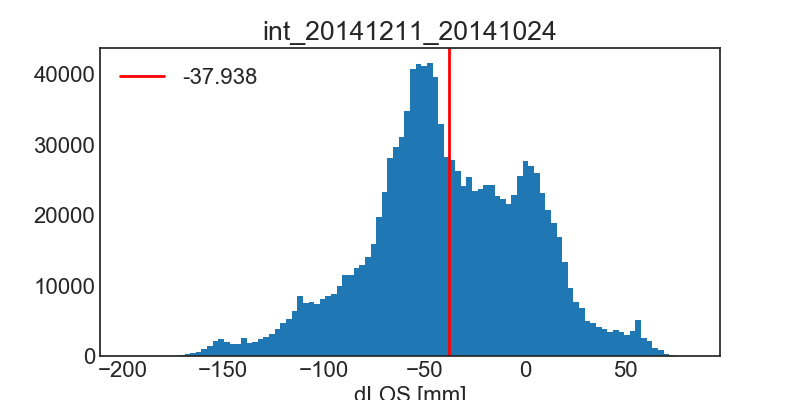

In [93]:
plot_histogram(mm)

In [131]:
# Plot EW and North-South profiles to get a feel for ramps
def EW_profile_summary(mm, pair):
    x = np.arange(mm.shape[1])
    ewAve = np.nanmean(mm, axis=0)
    ewStd = np.nanstd(mm, axis=0)
    plt.figure()
    plt.errorbar(x, ewAve, ewStd, ecolor='gray', fmt='k.')
    plt.title('EW Profiles: {}'.format(pair))
    plt.xlabel('Column #')
    plt.ylabel('dLOS [mm]')
    plt.savefig('{}_EW.pdf'.format(pair))

In [132]:
# Plot EW and North-South profiles to get a feel for ramps
def NS_profile_summary(mm, pair):
    x = np.arange(mm.shape[0])
    nsAve = np.nanmean(mm, axis=1)
    nsStd = np.nanstd(mm, axis=1)
    plt.figure()
    plt.errorbar(x, nsAve, nsStd, ecolor='gray', fmt='k.')
    plt.title('NS Profiles: {}'.format(pair))
    plt.xlabel('Row #')
    plt.ylabel('dLOS [mm]')
    plt.savefig('{}_NS.pdf'.format(pair))

/Users/scott/miniconda3/envs/forge2017/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/scott/miniconda3/envs/forge2017/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


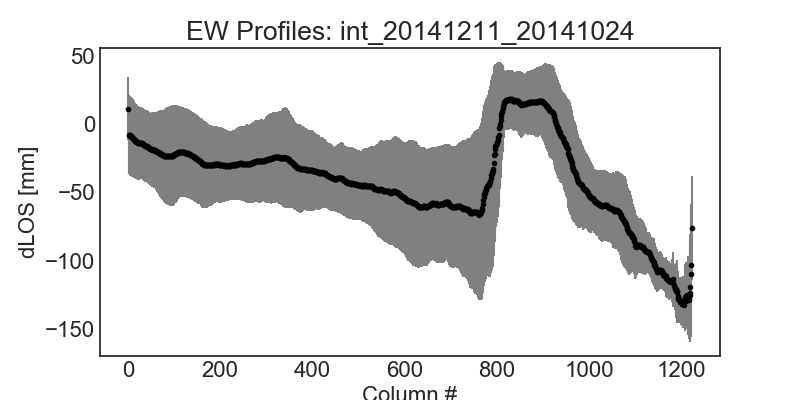

<IPython.core.display.Javascript object>


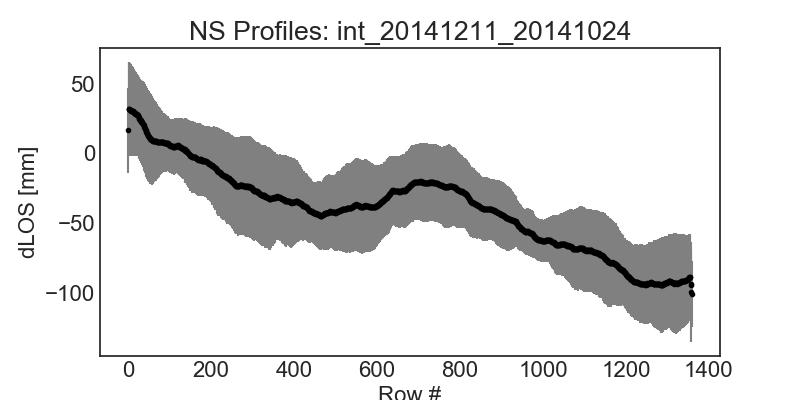

In [133]:
EW_profile_summary(mm, pair)
NS_profile_summary(mm, pair)

In [157]:
# Save Images and profiles of every image
''' 
plt.ioff() #Turn off temporarily to prevent cell output

def save_image(mm, pair, extent=None, vmin=None, vmax=None, cmap='viridis'):
    plt.figure()
    plt.imshow(mm, extent=None, cmap=cmap, vmin=vmin, vmax=vmax)
    cb = plt.colorbar()
    cb.set_label('dLOS [mm]')
    plt.title(pair)
    plt.savefig('{}_MM.pdf'.format(pair))
    
for i,row in dfAll[:3].iterrows():
    pair = row.directory
    print(pair)
    path = os.path.join(datadir,pair,unwFile)
    mm,extent,metadata = load_mm(path, mask=water)
    extent_km = np.array(extent)/1e3
    save_image(mm, pair, extent)
    EW_profile_summary(mm, pair)
    NS_profile_summary(mm, pair)
    
'''

int_20141117_20141012


/Users/scott/miniconda3/envs/forge2017/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/scott/miniconda3/envs/forge2017/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


int_20141117_20141024
int_20141129_20141012


In [158]:
plt.ion()

# Definitely linear trends in each direction, suggesting need for ramp removal. Not bump in EW profile due to bias towards only valid pixels north of the Lake

# Timeseries *for now truncate to first ~30 dates

In [159]:
df = dfAll.iloc[:30]
dfDates = summarize_dates(df)
print(len(df), ' Interferograms')
print(len(dfDates), 'Dates')
print('First Date: ', df.secondary.iloc[0])
print('Second Date: ', df.primary.iloc[-1])
dfDates

30  Interferograms
13 Dates
First Date:  2014-10-12 00:00:00
Second Date:  2015-03-29 00:00:00


,count,p_pairs,s_pairs
2014-10-12,2.0,0.0,2.0
2014-10-24,3.0,0.0,3.0
2014-11-17,5.0,2.0,3.0
2014-11-29,6.0,3.0,3.0
2014-12-11,6.0,3.0,3.0
2014-12-23,6.0,3.0,3.0
2015-01-04,6.0,3.0,3.0
2015-01-16,6.0,3.0,3.0
2015-01-28,6.0,3.0,3.0
2015-02-09,5.0,3.0,2.0


In [200]:
# Collect unwrapped phase, and connected component arrays into stacks
# Since arrays aren't too big, load everything into 3D array in memory, masking everything but region of interest
print('Loading all data into memory...')
array_list = []

for i,row in df.iterrows():
    pair = row.directory
    print(pair)
    path = os.path.join(datadir,pair,unwFile)
    mm,extent,metadata = load_mm(path, mask=water)
    array_list.append(mm) 

Loading all data into memory...
int_20141117_20141012
int_20141117_20141024
int_20141129_20141012
int_20141129_20141024
int_20141129_20141117
int_20141211_20141024
int_20141211_20141117
int_20141211_20141129
int_20141223_20141117
int_20141223_20141129
int_20141223_20141211
int_20150104_20141129
int_20150104_20141211
int_20150104_20141223
int_20150116_20141211
int_20150116_20141223
int_20150116_20150104
int_20150128_20141223
int_20150128_20150104
int_20150128_20150116
int_20150209_20150104
int_20150209_20150116
int_20150209_20150128
int_20150221_20150116
int_20150221_20150128
int_20150221_20150209
int_20150305_20150128
int_20150305_20150209
int_20150305_20150221
int_20150329_20150221


In [203]:
# Make 3D numpy array : NOTE: later try this with xarray
ifgs = np.dstack(array_list)

In [204]:
# Add simple statistics to dataframe #ignore warning, seems to work fine...
#NOTE: can change b/c already loaded...
for i,row in df.iterrows():
    pair = row.directory
    print(pair)
    path = os.path.join(datadir,pair,unwFile)
    mm,extent,metadata = load_mm(path, mask=water)
    df.loc[i,'allMean'] =  np.nanmean(mm)
    df.loc[i,'allStd'] =  np.nanstd(mm)

int_20141117_20141012


/Users/scott/miniconda3/envs/forge2017/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


int_20141117_20141024
int_20141129_20141012
int_20141129_20141024
int_20141129_20141117
int_20141211_20141024
int_20141211_20141117
int_20141211_20141129
int_20141223_20141117
int_20141223_20141129
int_20141223_20141211
int_20150104_20141129
int_20150104_20141211
int_20150104_20141223
int_20150116_20141211
int_20150116_20141223
int_20150116_20150104
int_20150128_20141223
int_20150128_20150104
int_20150128_20150116
int_20150209_20150104
int_20150209_20150116
int_20150209_20150128
int_20150221_20150116
int_20150221_20150128
int_20150221_20150209
int_20150305_20150128
int_20150305_20150209
int_20150305_20150221
int_20150329_20150221


In [205]:
df.head()

,directory,primary,secondary,dt,allMean,allStd,test
0,int_20141117_20141012,2014-11-17,2014-10-12,36 days,-80.530273,37.080677,0
1,int_20141117_20141024,2014-11-17,2014-10-24,24 days,-82.079407,22.793076,0
2,int_20141129_20141012,2014-11-29,2014-10-12,48 days,-22.521662,42.400414,0
3,int_20141129_20141024,2014-11-29,2014-10-24,36 days,22.154984,50.491669,0
4,int_20141129_20141117,2014-11-29,2014-11-17,12 days,56.587807,42.459854,0


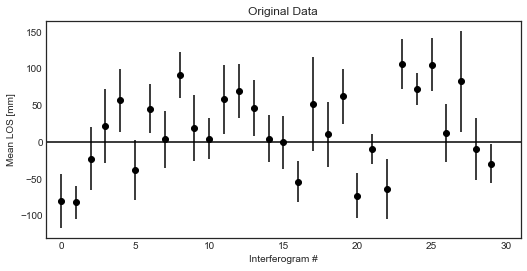

In [208]:
plt.figure(figsize=(8.5,4))
plt.errorbar(df.index.values, df.allMean, df.allStd, fmt='ko')
plt.xlabel('Interferogram #')
plt.ylabel('Mean LOS [mm]')
plt.xlim(-1,len(df)+1)
plt.title('Original Data')
plt.axhline(color='k')

In [217]:
ifgs = np.dstack(array_list)
ramps = np.dstack(df.allMean.values) #subtract mean value from each
stack = ifgs - ramps
cumdef = stack.sum(axis=2) #cumulative deformation
ave = cumdef / stack.shape[-1] #average by number of observations

In [218]:
# Probably a better way of doing this...
#aveNorm = np.nanmean(np.nanmean(stack, axis=0), axis=0)
#stdNorm = np.nanstd(np.nanstd(stack, axis=0), axis=0)
aveNorm = np.nanmean(d_flat, axis=-1)
stdNorm = np.nanstd(d_flat, axis=-1)

/Users/scott/miniconda3/envs/forge2017/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/Users/scott/miniconda3/envs/forge2017/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


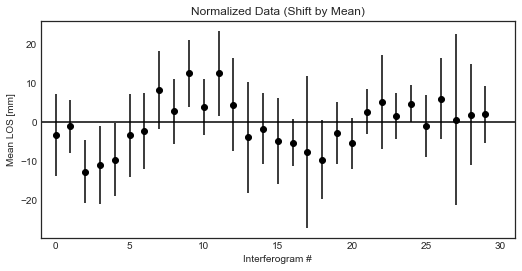

In [219]:
plt.figure(figsize=(8.5,4))
plt.errorbar(df.index.values, aveNorm, stdNorm, fmt='ko') #Something very odd here... 
plt.xlabel('Interferogram #')
plt.ylabel('Mean LOS [mm]')
plt.xlim(-1,len(df)+1)
plt.title('Normalized Data (Shift by Mean)')
plt.axhline(color='k')

### Not sure what to make of this quasi-seasonal signal after shifting by the mean!

Text(0.5,1,'stack')

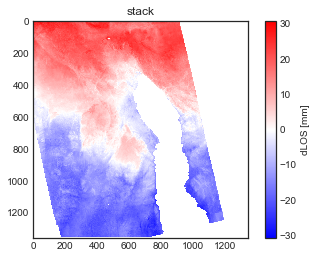

In [220]:
plot_image(ave, vmin=None, vmax=None, cmap='bwr')
plt.title('stack')

# Need to do more sophisticated ramp removal

In [224]:
# Remove Ramp from each
ramp_list = []
for ifg in array_list:
    ramp = util.calc_ramp(ifg, water)
    ramp_list.append(ramp)


In [ ]:
ramps = np.dstack(ramp_list)
stack= ifgs - ramps
cumdef = stack.sum(axis=2) #cumulative deformation
ave = cumdef / stack.shape[-1] #average by number of observatuins

/Users/scott/miniconda3/envs/forge2017/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Text(0.5,1,'stack')

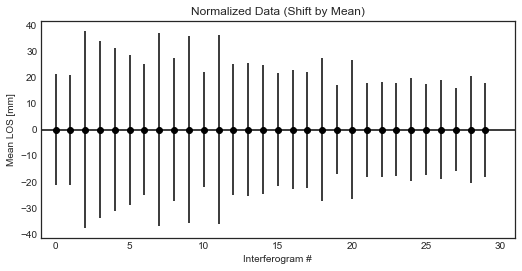

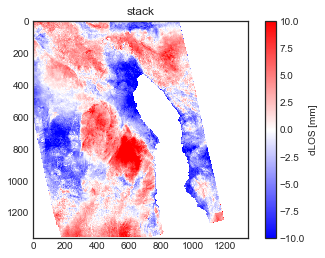

In [275]:
d = np.rollaxis(stack,-1) #[in,row,col] index
d_flat = d.reshape(d.shape[0], -1)
aveNorm = np.nanmean(d_flat, axis=-1)
stdNorm = np.nanstd(d_flat, axis=-1)
df.loc[:, 'normMean'] = aveNorm
df.loc[:, 'normStd'] = stdNorm

plt.figure(figsize=(8.5,4))
plt.errorbar(df.index.values, aveNorm, stdNorm, fmt='ko') #Something very odd here... 
plt.xlabel('Interferogram #')
plt.ylabel('Mean LOS [mm]')
plt.xlim(-1,len(df)+1)
plt.title('Normalized Data (Shift by Mean)')
plt.axhline(color='k')

plot_image(ave, vmin=-10, vmax=10, cmap='bwr')
plt.title('stack')

# Scenes  are normalized to zero mean, but overal variance increases considerably...

-3.45861620886e-12
21.3321442538


Text(0,0.5,'Northing [km]')

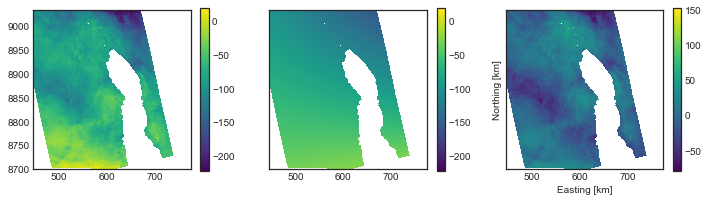

In [276]:
# Check ramp removal for particular IFG
shrink=0.5
i = 0
mm = ifgs[:,:,i]
ramp = ramps[:,:,i]
ramp[np.isnan(mm)] = np.nan

fig,axes = plt.subplots(1,3,figsize=(12,6),sharex=True, sharey=True,subplot_kw=dict(adjustable='box-forced'))
plt.sca(axes[0])
im = plt.imshow(mm, extent=extent_km)
plt.colorbar(shrink=shrink)
plt.sca(axes[1])
plt.imshow(ramp, extent=extent_km, norm=im.norm)
plt.colorbar(shrink=shrink)
plt.sca(axes[2])
plt.imshow(mm-ramp, extent=extent_km)
print(np.nanmean(mm-ramp))
print(np.nanstd(mm-ramp))
plt.colorbar(shrink=shrink)
#plt.xlim(570,600)
#plt.ylim(8900, 8930)
plt.xlabel('Easting [km]')
plt.ylabel('Northing [km]')

-3.45861620886e-12
-5.56485892764e-12
-5.34557370945e-12


Text(0.5,1,'IFG2')

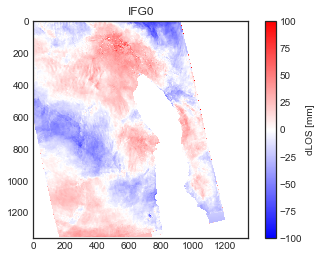

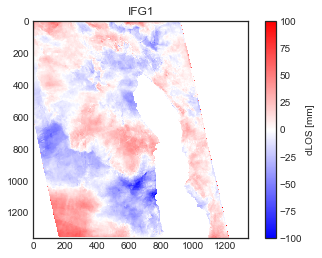

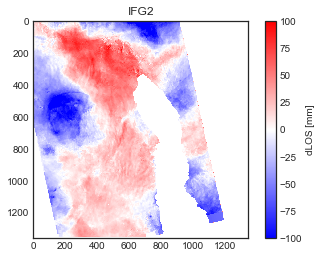

In [278]:
# For now, just crop all data to Northern section of lake and common reference point?
# NOTE: first and last dates particularly important...
i=0
plot_image(stack[:,:,i], cmap='bwr', vmin=-100, vmax=100)
print(np.nanmean(stack[:,:,0]))
plt.title('IFG{}'.format(i))

i=1
plot_image(stack[:,:,i], cmap='bwr', vmin=-100, vmax=100)
print(np.nanmean(stack[:,:,i]))
plt.title('IFG{}'.format(i))

i=2
plot_image(stack[:,:,i], cmap='bwr', vmin=-100, vmax=100)
print(np.nanmean(stack[:,:,i]))
plt.title('IFG{}'.format(i))

<IPython.core.display.Javascript object>


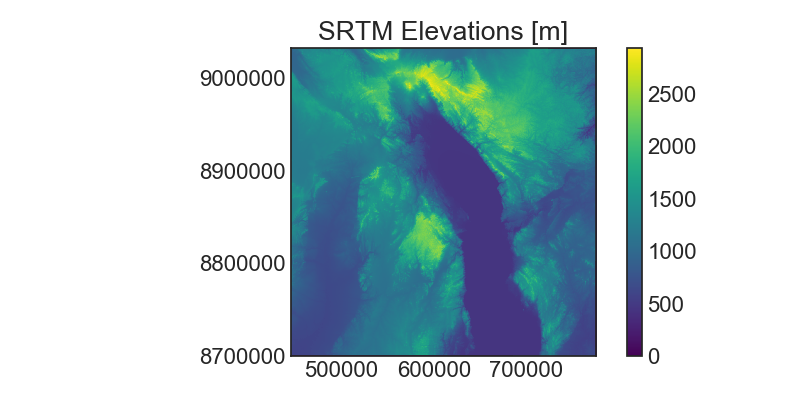

In [36]:
# Get SRTM elevation
data,junk,junk = util.load_rasterio(demFile)
elev = data[0]

plt.figure()
plt.imshow(elev, extent=extent, cmap='viridis')
plt.title('SRTM Elevations [m]')
plt.colorbar()

In [50]:
# Add MATL
pMATL = (34.5847, -9.592)
xcen,ycen = utm36s(*pMATL)
print(xcen,ycen)
lon,lat = utm36s(xcen,ycen,inverse=True)
print(lon,lat)

# Get pixel coordinates from UTM
rcen,ccen = util.world2rc(xcen, ycen, metadata['affine']) 
print(rcen, ccen)

673909.3607564468 8939296.05491381
34.5847 -9.59200000000001
381 934


<IPython.core.display.Javascript object>


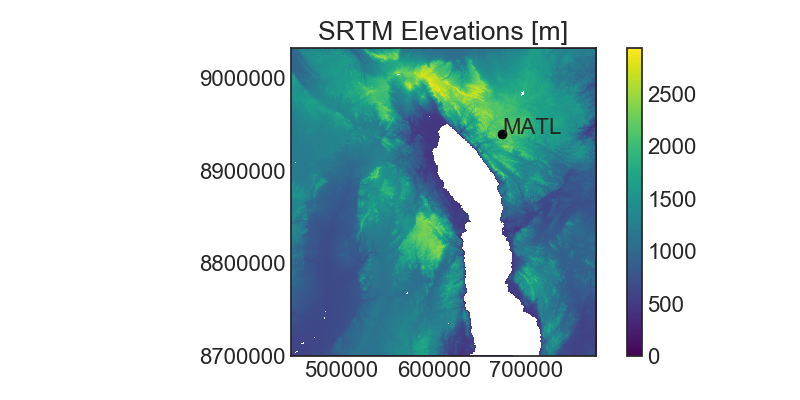

In [41]:
# Apply mask to image
# Get General Masks
elev_masked = elev.astype('f4')
elev_masked[water] = np.nan

plt.figure()
plt.imshow(elev_masked, extent=extent, cmap='viridis')
plt.plot(xcen,ycen,'ko')
plt.text(xcen,ycen,'MATL')
plt.title('SRTM Elevations [m]')
plt.colorbar()

<IPython.core.display.Javascript object>


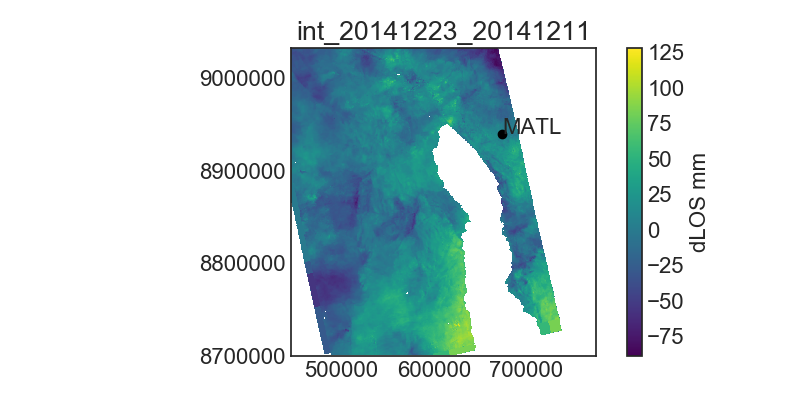

In [44]:
# Add Regional of interest around MATL
ifg = 10
pair = dfAll.directory.iloc[ifg]
path = os.path.join(datadir,pair,unwFile)
mm,extent,metadata = load_mm(path)
extent_km = np.array(extent)/1e3
mm[water] = np.nan

plt.figure()
plt.imshow(mm, extent=extent, cmap='viridis')
plt.plot(xcen,ycen,'ko')
plt.text(xcen,ycen,'MATL')
plt.title(pair)
cb = plt.colorbar()
cb.set_label('dLOS mm')

In [57]:
# Load all GPS stations as geodataframe
gf = gpd.read_file('segment_gps.shp')
gf = gf.to_crs({'init': 'epsg:{}'.format(epsg)})
gf

,site,start_x,end_x,geometry
0,CTPM,2013.1636,2016.5120,POINT (528849.6493080447 8927601.382097611)
1,DODC,2009.3854,2010.6092,POINT (804172.2181219532 9317262.948938161)
2,DODM,2010.7242,2015.6879,POINT (804151.480241904 9315392.715688607)
3,KA01,2013.1061,2014.1903,POINT (598160.30268295 8899529.760002693)
4,KASM,2013.1718,2015.4470,POINT (305519.6237622374 8875082.531974692)
5,KFNY,2012.5640,2016.3970,POINT (730785.9572287461 8943991.700246381)
6,LCNG,2013.5524,2015.2827,POINT (743058.1131999966 8528448.966386279)
7,LIVA,2013.1636,2016.3066,POINT (621105.6763601794 8826517.878102602)
8,LLNG,2009.0541,2013.1116,POINT (585280.6241451354 8457993.595414989)
9,MATL,2012.5503,2016.3723,POINT (673909.3607564468 8939296.05491381)


<IPython.core.display.Javascript object>


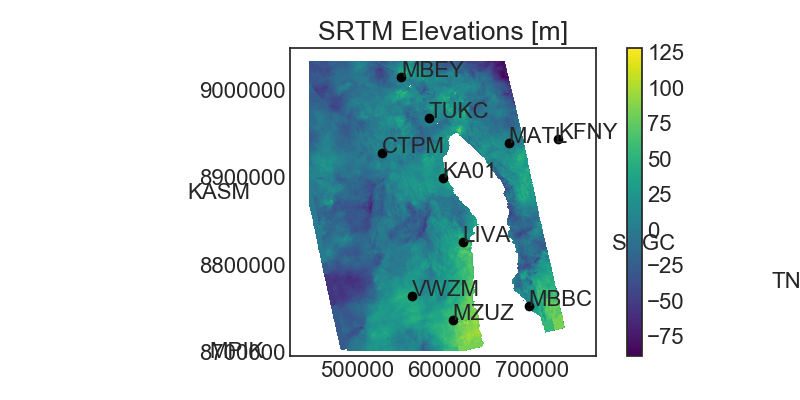

In [64]:
plt.figure()
plt.imshow(mm, extent=extent, cmap='viridis')

for i,row in gf.iterrows():
    plt.plot(row.geometry.x, row.geometry.y, 'ko')
    plt.text(row.geometry.x, row.geometry.y, row.site)

plt.title('SRTM Elevations [m]')
plt.colorbar()

### Region of interest = 10km around point MATL
### Need common reference point for scenes (Try approx same elvation 50km NW of MATL

In [69]:
xref = 644255.0
yref = 8970000.0

In [13]:
# Add Regional of interest around MATL
ifg = 10
pair = dfAll.directory.iloc[ifg]
path = os.path.join(datadir,pair,unwFile)
mm,extent,metadata = load_mm(path)
extent_km = np.array(extent)/1e3
mm[water] = np.nan

plt.figure()
plt.imshow(mm, extent=extent, cmap='viridis')
plt.plot(xcen,ycen,'ko')
plt.text(xcen,ycen,'MATL')
plt.plot(xref,yref,'wo')
plt.text(xref,yref,'Reference')
plt.title(pair)
cb = plt.colorbar()
cb.set_label('dLOS mm')

NameError: name 'water' is not defined

# Finally,,, a timeseries

In [288]:
# Now overdetermined problem
# Create G matrix (many ways to do this...)
m_ints = len(df)
n_date = len(dfDates)
n_rows, n_cols = stack.shape[:2] #number of rows and columns in each interferogram

G = np.zeros((m_ints,n_date)) #i,j row,col indexing

sD = pd.Series(np.arange(n_date), index=dfDates.index) #Date lookup table

for i,row in df.iterrows():
    j = sD[row.primary]
    k = sD[row.secondary]
    G[i,j] = 1 #Note:  fix first date to be zero?
    G[i,k] = -1
    
#print(G)
d = np.rollaxis(stack,-1)
d_flat = d.reshape(d.shape[0], -1)

In [290]:
m,residuals,rank,s = np.linalg.lstsq(G,d_flat)
m = m.reshape( (n_date,n_rows,n_cols))

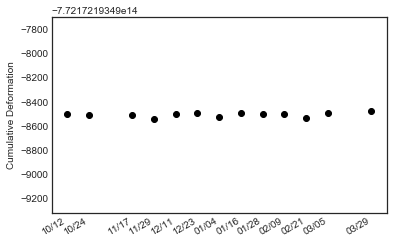

In [305]:
ts = m[:, rcen, ccen]
x = sD.index.values
fig,ax = plt.subplots()
plt.plot(x, ts, 'ko')
plt.xticks(x)
ax.xaxis.set_major_formatter(DateFormatter("%m/%d"))
plt.ylabel('Cumulative Deformation')
fig.autofmt_xdate()

## Didn't work b/c ill-conditioned. need to force first date to zero or some other constraint

In [344]:
G = np.matrix(G)
d = np.matrix(d_flat)
n_pix = d.shape[-1]

F = np.matrix(np.zeros(n_date))
F[0,0] = 1
h = np.matrix(np.zeros(n_pix)) #fixes initial position to zero...

Gaug = np.r_[np.c_[G.T*G, F.T], np.c_[F, np.matrix(0)]]
daug = np.r_[G.T*d, h]

maug = Gaug.I *daug
m_est = maug[:-1]

d_est = G*m_est

In [345]:
d_est.shape

(30, 1835989)

In [358]:
# Cumulative deformation at each date
m_ts = np.array(m_est)
m_ts = m_ts.reshape(n_date, n_rows, n_cols)

# Reconstructed interferograms
d_ts = np.array(d_est)
d_ts = d_ts.reshape(m_ints, n_rows, n_cols)

In [359]:
d_ts.shape

(30, 1361, 1349)

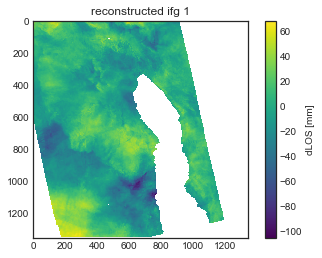

In [370]:
i = 1
plot_image(d_ts[i], title='reconstructed ifg {}'.format(i))

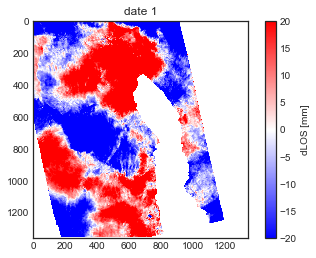

In [371]:
#NOTE: this should be a blend of atmospheric components on dates 1 & 2
i = 1
plot_image(m_ts[i], title='date {}'.format(i), vmin=-20, vmax=20, cmap='bwr')


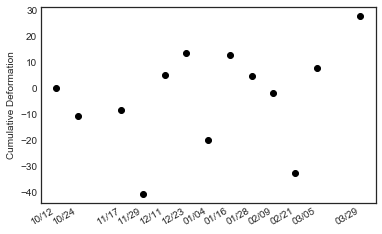

In [375]:
# Plot timeseries for a given pixel
ts = m_ts[:, rcen, ccen]
x = sD.index.values
fig,ax = plt.subplots()
plt.plot(x, ts, 'ko')
plt.xticks(x)
ax.xaxis.set_major_formatter(DateFormatter("%m/%d"))
plt.ylabel('Cumulative Deformation')
fig.autofmt_xdate()

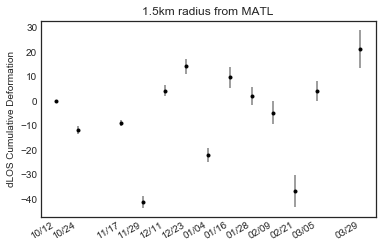

In [398]:
# Better to do average of several pixels? at 8lks, each pixel is ~250 m^2
pad=3
ts = m_ts[:, rcen-pad:rcen+pad , ccen-pad:ccen+pad]
aveTS = ts.reshape(ts.shape[0],-1).mean(axis=-1)
stdTS = ts.reshape(ts.shape[0],-1).std(axis=-1)

x = sD.index.values
fig,ax = plt.subplots()
#plt.plot(x, ts, 'ko')
plt.errorbar(x, aveTS, stdTS, fmt='k.', ecolor='gray')
plt.title('1.5km radius from MATL')

plt.xticks(x)
ax.xaxis.set_major_formatter(DateFormatter("%m/%d"))
plt.ylabel('dLOS Cumulative Deformation')
fig.autofmt_xdate()


### Would regularlized inversion deal w/ outlier dates? 
### How does including more data influence result?

In [18]:
# Try Inversion with dates through 10/2014 - 06/2016
df = dfAll.query('primary < "2016-06-01" ') #Warning crashes b/c insufficient memory

dfDates = summarize_dates(df)
print(len(df), ' Interferograms')
print(len(dfDates), 'Dates')
print('First Date: ', dfDates.index[0])
print('Last Date: ', dfDates.index[-1])
dfDates.tail()

84  Interferograms
47 Dates
First Date:  2014-10-12 00:00:00
Last Date:  2016-05-10 00:00:00


,count,p_pairs,s_pairs
2016-03-23,2.0,1.0,1.0
2016-04-04,3.0,2.0,1.0
2016-04-16,3.0,1.0,2.0
2016-04-28,2.0,1.0,1.0
2016-05-10,2.0,2.0,0.0


In [19]:
# Load data and add basic statistics to dataframe
# Add simple statistics to dataframe #ignore warning, seems to work fine...
#NOTE: can change b/c already loaded...
print('Loading all data into memory...') #NOTE: each array is 7Mb
array_list = []

for i,row in df.iterrows():
    pair = row.directory
    #print(pair)
    path = os.path.join(datadir,pair,unwFile)
    mm,extent,metadata = load_mm(path, mask=water)
    array_list.append(mm)
    df.loc[i,'allMean'] =  np.nanmean(mm)
    df.loc[i,'allStd'] =  np.nanstd(mm)

Loading all data into memory...


/Users/scott/miniconda3/envs/forge2017/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/scott/miniconda3/envs/forge2017/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
# Remove Ramp from each
ramp_list = []
for ifg in array_list:
    ramp = util.calc_ramp(ifg, water)
    ramp_list.append(ramp)

In [26]:
# Put into 3D array
ifgs = np.dstack(array_list)
ramps = np.dstack(ramp_list) 
stack = ifgs - ramps 
#cumdef = stack.sum(axis=2) #cumulative deformation
#ave = cumdef / stack.shape[-1] #average by number of observations

#NOTE: usage ~ 3Gb
# Free up memory
del array_list
del ramp_list

/Users/scott/miniconda3/envs/forge2017/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/scott/miniconda3/envs/forge2017/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<IPython.core.display.Javascript object>


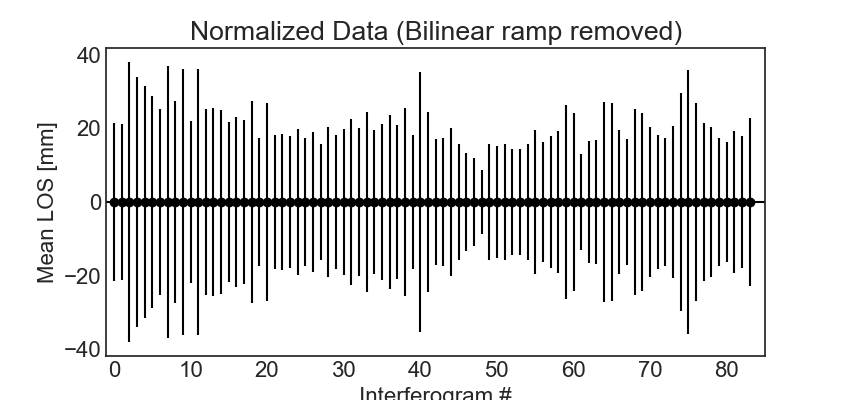

In [31]:
# Check that data is normalized
d = np.rollaxis(stack,-1) #[in,row,col] index
d_flat = d.reshape(d.shape[0], -1)
aveNorm = np.nanmean(d_flat, axis=-1)
stdNorm = np.nanstd(d_flat, axis=-1)
df.loc[:, 'normMean'] = aveNorm
df.loc[:, 'normStd'] = stdNorm

plt.figure(figsize=(8.5,4))
plt.errorbar(df.index.values, aveNorm, stdNorm, fmt='ko') #Something very odd here... 
plt.xlabel('Interferogram #')
plt.ylabel('Mean LOS [mm]')
plt.xlim(-1,len(df)+1)
plt.title('Normalized Data (Bilinear ramp removed)')
plt.axhline(color='k')

In [32]:
# Prep Inversion
# Now overdetermined problem
# Create G matrix (many ways to do this...)
m_ints = len(df)
n_date = len(dfDates)
n_rows, n_cols = stack.shape[:2] #number of rows and columns in each interferogram

G = np.zeros((m_ints,n_date)) #i,j row,col indexing

sD = pd.Series(np.arange(n_date), index=dfDates.index) #Date lookup table

for i,row in df.iterrows():
    j = sD[row.primary]
    k = sD[row.secondary]
    G[i,j] = 1 #Note:  fix first date to be zero?
    G[i,k] = -1


In [33]:
# Run Inversion w/ augmented matrix to fix first date to zero
G = np.matrix(G)
d = np.matrix(d_flat)
n_pix = d.shape[-1]

F = np.matrix(np.zeros(n_date))
F[0,0] = 1
h = np.matrix(np.zeros(n_pix)) #fixes initial position to zero...

Gaug = np.r_[np.c_[G.T*G, F.T], np.c_[F, np.matrix(0)]]
daug = np.r_[G.T*d, h]

maug = Gaug.I *daug
m_est = maug[:-1]

d_est = G*m_est

# NOTE: memory 6.6Gb

In [46]:
# Convert from Matrix to Array type for further analysis
# Cumulative deformation at each date
m_ts = np.array(m_est)
m_ts = m_ts.reshape(n_date, n_rows, n_cols)

# Reconstructed interferograms
d_ts = np.array(d_est)
d_ts = d_ts.reshape(m_ints, n_rows, n_cols)

In [54]:
del d_flat, d_est, m_est

NameError: name 'd_est' is not defined

<IPython.core.display.Javascript object>


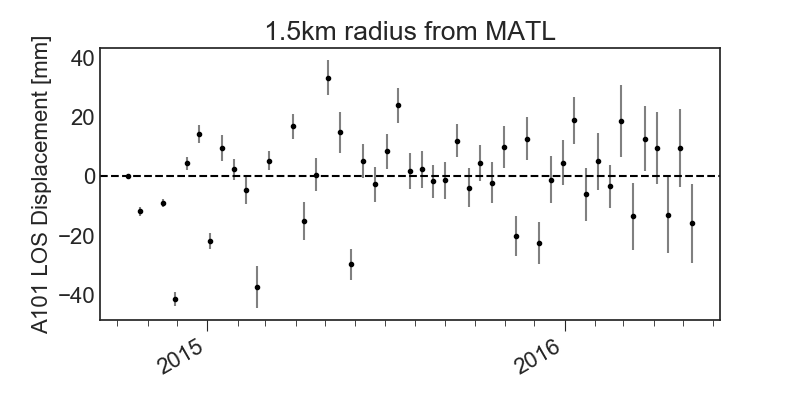

In [61]:
# Better to do average of several pixels? at 8lks, each pixel is ~250 m^2
pad=3
ts = m_ts[:, rcen-pad:rcen+pad , ccen-pad:ccen+pad]
aveTS = ts.reshape(ts.shape[0],-1).mean(axis=-1)
stdTS = ts.reshape(ts.shape[0],-1).std(axis=-1)

x = sD.index.values
fig,ax = plt.subplots(figsize=(8,4))
#plt.plot(x, ts, 'ko')
plt.errorbar(x, aveTS, stdTS, fmt='k.', ecolor='gray')
plt.ylabel('A101 LOS Displacement [mm]')
plt.title('1.5km radius from MATL')


# Label specific dates
#plt.xticks(x)
#ax.xaxis.set_major_formatter(DateFormatter("%m/%d"))
#plt.ylabel('dLOS Cumulative Deformation')
#fig.autofmt_xdate()
plt.axhline(0, color='k', linestyle='dashed')

months = pltdate.MonthLocator()
years = pltdate.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months) #too much
ax.fmt_xdata = pltdate.DateFormatter('%Y-%m-%d')

plt.tick_params(axis='x', which='minor', bottom=True, length=4)
plt.tick_params(axis='x', which='major', bottom=True, length=8)

fig.autofmt_xdate()
plt.savefig('timeseries_MATL.pdf', bbox_inches='tight')

In [40]:
import sys
def show_mem_usage():
    '''Displays memory usage from inspection
    of global variables in this notebook'''
    gl = sys._getframe(1).f_globals
    vars= {}
    for k,v in list(gl.items()):
        # for pandas dataframes
        if hasattr(v, 'memory_usage'):
            mem = v.memory_usage(deep=True)
            if not np.isscalar(mem):
                mem = mem.sum()
            vars.setdefault(id(v),[mem]).append(k)
        # work around for a bug
        elif isinstance(v,pd.Panel):
            v = v.values
        vars.setdefault(id(v),[sys.getsizeof(v)]).append(k)
    total = 0
    for k,(value,*names) in vars.items():
        if value>1e6:
            print(names,"%.3fMB"%(value/1e6))
        total += value
    print("%.3fMB"%(total/1e6))

In [41]:
show_mem_usage()

['ifg', 'mm'] 7.344MB
['data'] 1.836MB
['water'] 1.836MB
['ifgs'] 616.892MB
['ramps'] 1233.785MB
['d'] 1233.785MB
['maug'] 705.020MB
['d_est'] 1233.785MB
5034.368MB


In [43]:
#del stack, F, h, Gaug, maug, ifgs, ramps

In [56]:
show_mem_usage()

['ifg', 'mm'] 7.344MB
['data'] 1.836MB
['water'] 1.836MB
['d'] 1233.785MB
1244.891MB
